In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
from rich import print as rprint
from torch import nn
from torch.utils.data import DataLoader

from analysis.common import load_model
from analysis.residual_alignment_methods import alignment, plotsvals, sab, trajectories

# from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    get_dataset_class,
)
from koopmann.models import MLP, ResMLP
from koopmann.utils import (
    compute_model_accuracy,
    get_device,
)
from koopmann.visualization import plot_decision_boundary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
file_dir = "/scratch/nsa325/koopmann_model_saves"
model_name = "resmlp"
device = get_device()

In [121]:
model, model_metadata = load_model(file_dir, model_name)
model.hook_model()
print(model_metadata)

{'batchnorm': True, 'bias': False, 'created_at': '2025-03-09T22:00:40.104381', 'dataset': 'LotusRootDataset', 'hidden_config': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'in_features': 2, 'model_class': 'ResMLP', 'nonlinearity': 'relu', 'out_features': 2, 'stochastic_depth_mode': 'batch', 'stochastic_depth_prob': 0.0}


In [122]:
# Dataset config
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"],
    num_samples=3_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = DataLoader(dataset, batch_size=1000)

In [123]:
rprint(f"Testing Accuracy: {compute_model_accuracy(model, dataloader, device)}")

Testing Accuracy: 0.9963333606719971

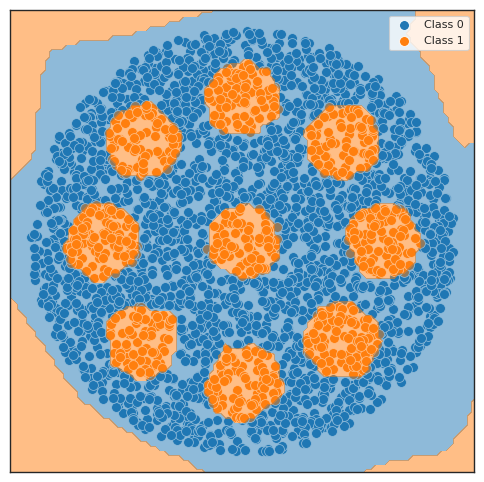

In [124]:
if dataset.in_features == 2:
    plot_decision_boundary(
        model,
        model.state_dict(),
        dataset.features,
        dataset.labels.squeeze(),
        labels=[0, 1, 2],
    )

In [125]:
inputs, labels = next(iter(dataloader))
_ = model(inputs)
act_dict = model.get_forward_activations()


def visualize_projection(features, labels, dim=3, seed=None):
    # Set seed for reproducibility if provided
    if seed is not None:
        torch.manual_seed(seed)

    # Create random projection matrix to target dimension
    input_dim = features.shape[1]
    projection_matrix = torch.randn(input_dim, dim)
    projected_features = features @ projection_matrix

    # Convert labels to 1D array
    labels_1d = labels.detach().cpu().numpy().flatten()

    # Convert to DataFrame
    if dim == 3:
        df = pd.DataFrame(projected_features.detach().cpu().numpy(), columns=["x", "y", "z"])
        fig = px.scatter_3d(
            df,
            x="x",
            y="y",
            z="z",
            color=labels_1d,  # Using flattened labels
            title=f"{dim}D Random Projection",
        )
    else:  # 2D case
        df = pd.DataFrame(projected_features.detach().cpu().numpy(), columns=["x", "y"])
        fig = px.scatter(
            df,
            x="x",
            y="y",
            color=labels_1d,  # Using flattened labels
            title=f"{dim}D Random Projection",
        )

    return fig


fig = visualize_projection(act_dict[0], labels=labels, dim=2)
fig.show()
